In [0]:
from tensorflow.keras.models import Sequential,  load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, Embedding, Bidirectional, Activation, SpatialDropout1D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputSpec, Layer, concatenate
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
from sklearn.utils import shuffle

In [0]:
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init,
                                 trainable=True)
        #self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / K.sum(ai, axis=1, keepdims=True)
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [0]:
def deepmoji_architecture(nb_classes, nb_tokens, maxlen, feature_output=False, embed_dropout_rate=0, final_dropout_rate=0, embed_l2=1E-6, return_attention=False):
    """
    Returns the DeepMoji architecture uninitialized and
    without using the pretrained model weights.
    # Arguments:
        nb_classes: Number of classes in the dataset.
        nb_tokens: Number of tokens in the dataset (i.e. vocabulary size).
        maxlen: Maximum length of a token.
        feature_output: If True the model returns the penultimate
                        feature vector rather than Softmax probabilities
                        (defaults to False).
        embed_dropout_rate: Dropout rate for the embedding layer.
        final_dropout_rate: Dropout rate for the final Softmax layer.
        embed_l2: L2 regularization for the embedding layerl.
    # Returns:
        Model with the given parameters.
    """
    # define embedding layer that turns word tokens into vectors
    # an activation function is used to bound the values of the embedding
    model_input = Input(shape=(maxlen,), dtype='int32')
    embed_reg = L1L2(l2=embed_l2) if embed_l2 != 0 else None
    embed = Embedding(input_dim=nb_tokens,
                      output_dim=256,
                      mask_zero=True,
                      input_length=maxlen,
                      embeddings_regularizer=embed_reg,
                      name='embedding')

    x = embed(model_input)
    x = Activation('tanh')(x)

    # entire embedding channels are dropped out instead of the
    # normal Keras embedding dropout, which drops all channels for entire words
    # many of the datasets contain so few words that losing one or more words can alter the emotions completely
    if embed_dropout_rate != 0:
        embed_drop = SpatialDropout1D(embed_dropout_rate, name='embed_drop')
        x = embed_drop(x)

    # skip-connection from embedding to output eases gradient-flow and allows access to lower-level features
    # ordering of the way the merge is done is important for consistency with the pretrained model
    lstm_0_output = Bidirectional(LSTM(512, return_sequences=True), name="bi_lstm_0")(x)
    lstm_1_output = Bidirectional(LSTM(512, return_sequences=True), name="bi_lstm_1")(lstm_0_output)
    x = concatenate([lstm_1_output, lstm_0_output, x])

    # if return_attention is True in AttentionWeightedAverage, an additional tensor
    # representing the weight at each timestep is returned
    weights = None
    x = AttentionWeightedAverage(name='attlayer', return_attention=return_attention)(x)
    if return_attention:
        x, weights = x

    if feature_output == False:
        # output class probabilities
        if final_dropout_rate != 0:
            x = Dropout(final_dropout_rate)(x)

        if nb_classes > 2:
            outputs = [Dense(nb_classes, activation='softmax', name='softmax')(x)]
        else:
            outputs = [Dense(1, activation='sigmoid', name='softmax')(x)]
    else:
        # output penultimate feature vector
        outputs = [x]

    if return_attention:
        # add the attention weights to the outputs if required
        outputs.append(weights)

    return Model(inputs=[model_input], outputs=outputs, name="DeepMoji")

In [0]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

def print_loss(history, title=''):
  plot_curves(f'{title} - Loss', 
            [
              history.history['loss'], history.history['val_loss']
            ], 'Loss', 'Epoch',
            [
              'Train', 'Valid'
            ]
            )
  
def print_acc(history, title=''):
  plot_curves(
      f'{title} - Accuracy', 
      [history.history['accuracy'], history.history['val_accuracy']], 
      'Accuracy', 'Epoch', 
      ['Train', 'Valid']
      )

In [8]:
train_data = np.load('./train.npz')
train_x, train_y = train_data['arr_0'], train_data['arr_1']
train_x.shape, train_y.shape

((25000, 130), (25000,))

In [7]:
test_data = np.load('./test.npz')
test_x, test_y = test_data['arr_0'], test_data['arr_1']
test_x.shape, test_y.shape

((25000, 130), (25000,))

In [0]:
test_x, test_y = shuffle(test_x, test_y, random_state=42)

In [0]:
train_x, train_y = shuffle(train_x, train_y, random_state=42)

In [44]:
model1 = deepmoji_architecture(nb_classes=2, nb_tokens=50000, maxlen=130)
model1.summary()

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1_cp = ModelCheckpoint('dpmj.hdf5', verbose=1, save_best_only=True)

Model: "DeepMoji"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 130)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 130, 256)     12800000    input_10[0][0]                   
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 130, 256)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 130, 1024)    3149824     activation_9[0][0]               
___________________________________________________________________________________________

In [45]:
model1_hist = model1.fit(train_x, train_y, batch_size=64, epochs=2, validation_split=0.2)

Epoch 1/2


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 334s 1s/step - loss: 0.4059 - accuracy: 0.8192 - val_loss: 0.3174 - val_accuracy: 0.8670
Epoch 2/2
313/313 [==============================] - 328s 1s/step - loss: 0.1987 - accuracy: 0.9283 - val_loss: 0.3531 - val_accuracy: 0.8692


In [46]:
m1_loss, m1_acc = model1.evaluate(test_x, test_y)
m1_loss, m1_acc

782/782 [==============================] - 113s 145ms/step - loss: 0.4061 - accuracy: 0.8434


(0.4060816168785095, 0.8434399962425232)

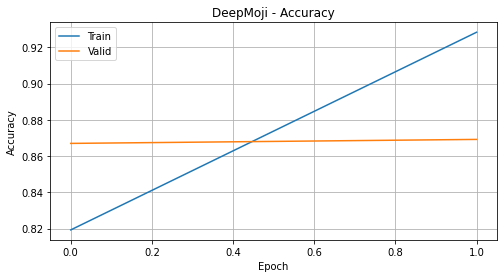

In [47]:
print_acc(model1_hist, 'DeepMoji')

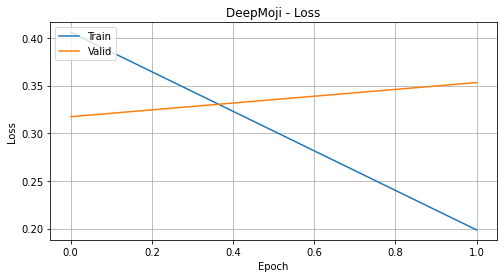

In [48]:
print_loss(model1_hist, 'DeepMoji')

In [0]:
import h5py
from os.path import exists

In [0]:
def get_weights_from_hdf5(filepath):
    """ Loads the weights from a saved Keras model into numpy arrays.
        The weights are saved using Keras 2.0 so we don't need all the
        conversion functionality for handling old weights.
    """

    with h5py.File(filepath, mode='r') as f:
        layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]
        layer_weights = []
        for k, l_name in enumerate(layer_names):
            g = f[l_name]
            weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
            weight_values = [g[weight_name][:] for weight_name in weight_names]
            if len(weight_values):
                layer_weights.append([l_name, weight_names, weight_values])
        return layer_weights

#model = load_model('deepmoji_model.h5', custom_objects={'AttentionWeightedAverage': AttentionWeightedAverage()})

In [53]:
!wget https://www.dropbox.com/s/xqarafsl6a8f9ny/deepmoji_weights.hdf5?dl=0#

--2020-04-05 11:52:03--  https://www.dropbox.com/s/xqarafsl6a8f9ny/deepmoji_weights.hdf5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xqarafsl6a8f9ny/deepmoji_weights.hdf5 [following]
--2020-04-05 11:52:03--  https://www.dropbox.com/s/raw/xqarafsl6a8f9ny/deepmoji_weights.hdf5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucedb1cf1deb39bc93020179ecd3.dl.dropboxusercontent.com/cd/0/inline/A1R-SuswZ2Odtw53DKU7nBUbhZiHsMyscRg-qnozemc5zTU0sSOZf92JGMqM3iXKkC4akW9PzD9OlyG0G_obDzK3kLiW2UpX3YkP8XDR4mMzkw/file# [following]
--2020-04-05 11:52:04--  https://ucedb1cf1deb39bc93020179ecd3.dl.dropboxusercontent.com/cd/0/inline/A1R-SuswZ2Odtw53DKU7nBUbhZiHsMyscRg-qnozemc5zTU0sSOZf92JGMqM3iXKkC4akW9PzD9OlyG0G_obDzK3kLiW2UpX3YkP

In [0]:
NB_TOKENS = 50000

In [0]:
def load_specific_weights(model, weight_path, exclude_names=[], extend_embedding=0, verbose=True):
    """ Loads model weights from the given file path, excluding any
        given layers.
    # Arguments:
        model: Model whose weights should be loaded.
        weight_path: Path to file containing model weights.
        exclude_names: List of layer names whose weights should not be loaded.
        extend_embedding: Number of new words being added to vocabulary.
        verbose: Verbosity flag.
    # Raises:
        ValueError if the file at weight_path does not exist.
    """
    if not exists(weight_path):
        raise ValueError('ERROR (load_weights): The weights file at {} does '
                         'not exist. Refer to the README for instructions.'
                         .format(weight_path))

    if extend_embedding and 'embedding' in exclude_names:
        raise ValueError('ERROR (load_weights): Cannot extend a vocabulary '
                         'without loading the embedding weights.')

    # Copy only weights from the temporary model that are wanted
    # for the specific task (e.g. the Softmax is often ignored)
    layer_weights = get_weights_from_hdf5(weight_path)
    for i, w in enumerate(layer_weights):
        l_name = w[0]
        weight_names = w[1]
        weight_values = w[2]

        if l_name in exclude_names:
            if verbose:
                print('Ignoring weights for {}'.format(l_name))
            continue

        try:
            model_l = model.get_layer(name=l_name)
        except ValueError:
            raise ValueError("Weights had layer {},".format(l_name) +
                             " but could not find this layer in model.")

        if verbose:
            print('Loading weights for {}'.format(l_name))

        # extend embedding layer to allow new randomly initialized words
        # if requested. Otherwise, just load the weights for the layer.
        if type(model_l) is Embedding and extend_embedding > 0:
            comb_weights = append_to_embedding(weight_values,
                                               model_l.get_weights())
            model_l.set_weights(comb_weights)
            if verbose:
                print('Extended vocabulary for embedding layer ' +
                      'from {} to {} tokens.'.format(
                          NB_TOKENS, NB_TOKENS + extend_embedding))
        else:
            model_l.set_weights(weight_values)

In [0]:
def change_trainable(layer, trainable, verbose=False):
    """ Helper method that fixes some of Keras' issues with wrappers and
        trainability. Freezes or unfreezes a given layer.
    # Arguments:
        layer: Layer to be modified.
        trainable: Whether the layer should be frozen or unfrozen.
        verbose: Verbosity flag.
    """

    layer.trainable = trainable

    if type(layer) == Bidirectional:
        layer.backward_layer.trainable = trainable
        layer.forward_layer.trainable = trainable

    if type(layer) == TimeDistributed:
        layer.backward_layer.trainable = trainable

    if verbose:
        action = 'Unfroze' if trainable else 'Froze'
        print("{} {}".format(action, layer.name))

In [0]:
def freeze_layers(model, unfrozen_types=[], unfrozen_keyword=None):
    """ Freezes all layers in the given model, except for ones that are
        explicitly specified to not be frozen.
    # Arguments:
        model: Model whose layers should be modified.
        unfrozen_types: List of layer types which shouldn't be frozen.
        unfrozen_keyword: Name keywords of layers that shouldn't be frozen.
    # Returns:
        Model with the selected layers frozen.
    """
    for l in model.layers:
        if len(l.trainable_weights):
            trainable = (type(l) in unfrozen_types or
                         (unfrozen_keyword is not None and unfrozen_keyword in l.name))
            change_trainable(l, trainable, verbose=False)
    return model

In [0]:
pre_trained = deepmoji_architecture(nb_classes=2, nb_tokens=50000, maxlen=130)

In [59]:
load_specific_weights(pre_trained, './deepmoji_weights.hdf5', exclude_names=['softmax'],)

Loading weights for embedding
Loading weights for bi_lstm_0
Loading weights for bi_lstm_1
Loading weights for attlayer
Ignoring weights for softmax


In [0]:
pre_trained = freeze_layers(pre_trained, unfrozen_keyword='softmax')

In [0]:
pre_trained.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [62]:
pre_trained.evaluate(test_x, test_y)

782/782 [==============================] - 150s 192ms/step - loss: 0.7140 - accuracy: 0.5001


[0.7139624357223511, 0.5001199841499329]

In [63]:
pre_trained.fit(train_x, train_y, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 374s 1s/step - loss: 0.7056 - accuracy: 0.5660 - val_loss: 0.6985 - val_accuracy: 0.5988
Epoch 2/5
313/313 [==============================] - 373s 1s/step - loss: 0.6931 - accuracy: 0.6025 - val_loss: 0.6894 - val_accuracy: 0.6020
Epoch 3/5
313/313 [==============================] - 377s 1s/step - loss: 0.6842 - accuracy: 0.6186 - val_loss: 0.6817 - val_accuracy: 0.6170
Epoch 4/5
313/313 [==============================] - 378s 1s/step - loss: 0.6769 - accuracy: 0.6272 - val_loss: 0.6767 - val_accuracy: 0.6264
Epoch 5/5
313/313 [==============================] - 371s 1s/step - loss: 0.6708 - accuracy: 0.6313 - val_loss: 0.6721 - val_accuracy: 0.6310


In [42]:
pre_trained.evaluate(test_x, test_y)

782/782 [==============================] - 147s 188ms/step - loss: 0.7184 - accuracy: 0.5067


[0.7183762788772583, 0.5067200064659119]